# Spectroscopy Lab

In this notebook we will focus on how to take the data we took of the sun and translate the lines into wavelengths. In order to do this we must first do two things: 
  1. Wrangle the data into a useable 1-D array. 
  2. Calibrate the focal length and measurements of the spectrometer using the mercury lamp readings 

## Data Wrangling

In order to graph the data, we must put the data into a 1 dimensional array. This means that we will take the fits image given to us and take a slice through the middle, along the x axis of the image.

## Calibration

The goal of this section is to translate the x axis in the above section from pixels to wavelengths. We will use the equations given in the lab to create a calibration framework for the spectra.  

##### Let's import the packages we will need:

In [1]:
from astropy.io import fits as pyfits
from astropy import units as u

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from glob import glob

## Data Wrangling

Here you provide path names to the mercury-argon and Sun spectral files. Remember to change the path name to where your data is stored.  Here we look at some example spectra from a previous quarter provided in the test_spectra/ folder.  

Make sure you analyze your own data!

In [2]:
TestSpectrumLoResFiles = {"Sun" : "test_spectra/SunLowRes5.6.00000001.FIT",
                          "Hg"  : "test_spectra/HgLowRes5.6.00000002.FIT"}

TestSpectrumHiResFiles = {"Sun" : {4.0 : 'test_spectra/SunHiRes4.0.00000004.FIT',
                                   4.4 : 'test_spectra/SunHiRes4.4.00000005.FIT'},
                          "Hg"  : {4.0 : 'test_spectra/HgHiRes4.0.00000003.FIT',
                                   4.4 : 'test_spectra/HgHiRes4.4.00000006.FIT'}}
# Example spectra are provided only for two micrometer settings.
# Change the lines above to import your spectra.
# Also, make sure to change the line below to the
# include all of the micrometer settings.
Micrometer = [4.0, 4.4]

In [3]:
#this is just the low res mercury calibration stuff alone
hdu = pyfits.open(TestSpectrumLoResFiles['Hg'])

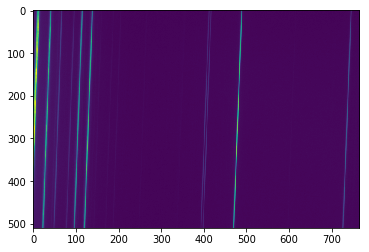

In [4]:
image_hdu = hdu[0]
spec_data = image_hdu.data
plt.imshow(spec_data)

You can see that this image is 2 dimensional, but that along the y-axis there is very little variablility. In order to cut this image to a 1-D array, we will take 10 of the central rows of data and average them so we get a good reading of the pixels. 

(510, 765)


(-0.5, 764.5, 9.5, -0.5)

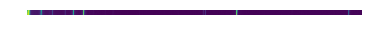

In [5]:
#first we get the central 10 rows of the image
print(spec_data.shape)
img_cut = spec_data[250:260]
plt.imshow(img_cut)
plt.axis('off')

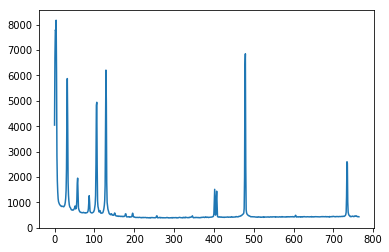

In [6]:
#then we average those ten rows so we get an accurate spectrum.
spectrum = np.average(img_cut, axis=0)
plt.plot(spectrum)

The data that comes directly from the spectrometer runs from red to blue (longer wavelengths to shorter wavelengths).  I find this confusing, so let's flip the spectrum

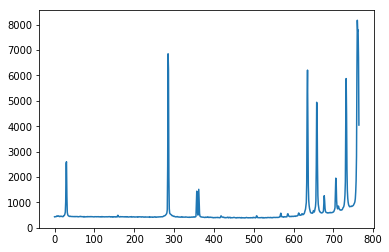

In [7]:
#FLIPPED VERSION
# turn the previous code into a function
# Flip the spectrum so that wavelength increases going from left to right
def spectrum(img_data, row_min, row_max):
    return np.flip(np.average(img_data[row_min:row_max,:], axis=0))
new_spectrum = spectrum(spec_data, 250, 260)
plt.plot(new_spectrum)

### Let's do this for all of the Spectra

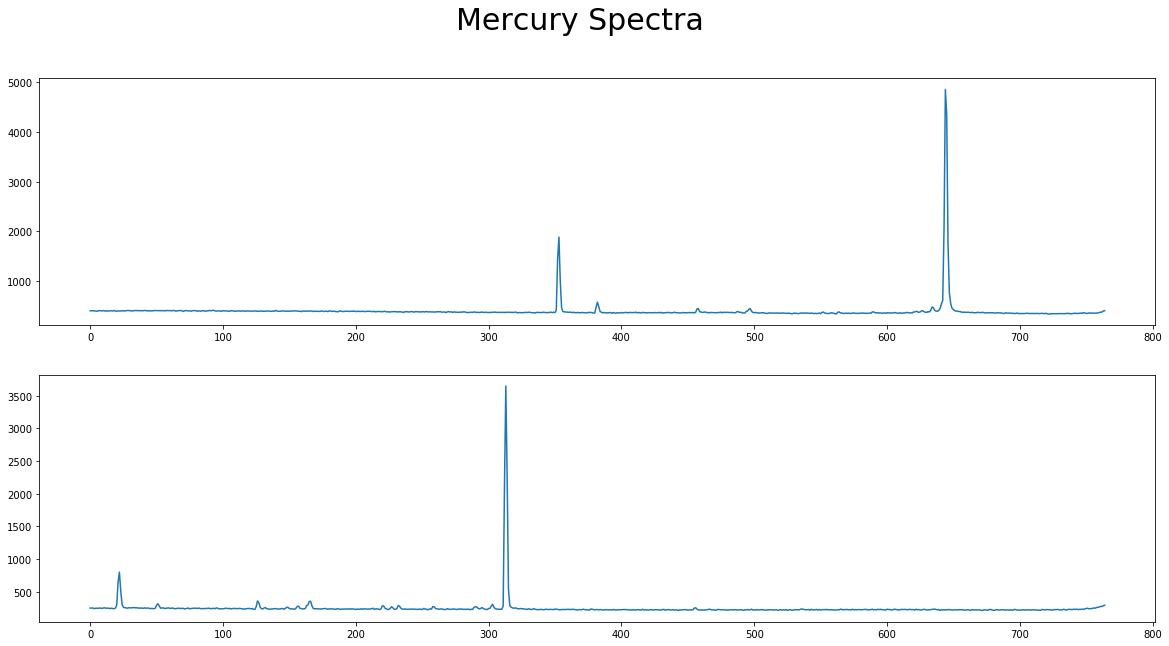

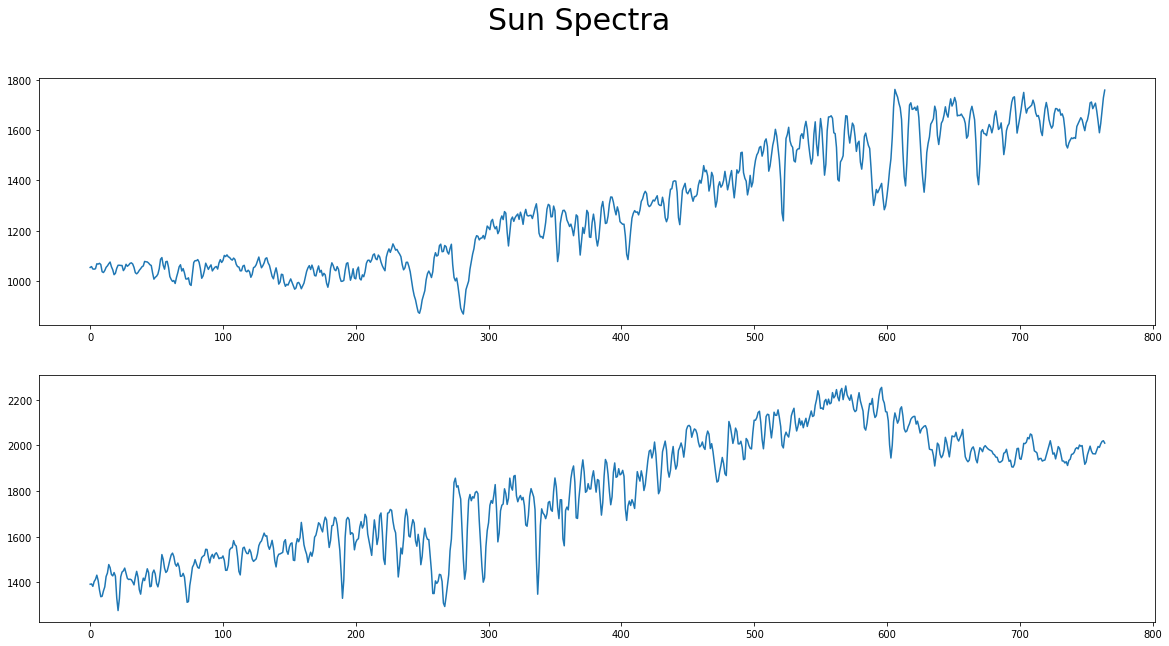

In [8]:
#getting the mercury spectra
Hg_spectra = []
Sun_spectra = []
for microm in Micrometer:
    Hg_hdu = pyfits.open(TestSpectrumHiResFiles['Hg'][microm])
    Sun_hdu = pyfits.open(TestSpectrumHiResFiles['Sun'][microm])
    Hg_spec_data = Hg_hdu[0].data
    Sun_spec_data = Sun_hdu[0].data
    Hg_spectra.append(spectrum(Hg_spec_data, 250, 260))
    Sun_spectra.append(spectrum(Sun_spec_data, 250, 260))
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
im1=ax1.plot(Hg_spectra[0])
im2=ax2.plot(Hg_spectra[1])
plt.suptitle("Mercury Spectra", fontsize=30)
plt.show()
    
fig, (ax1, ax2, ax2) = plt.subplots(3, 1, figsize=(20, 10))
im1=ax1.plot(Sun_spectra[0])
im2=ax2.plot(Sun_spectra[1])
plt.suptitle("Sun Spectra", fontsize=30)
plt.show()


## Calibration

In this portion, we will be relating pixel value to its corresponding wavelength. We wrangled the data into a 1-D line of pixel values, each taken at one micrometer setting, denoted by $\theta_i$. 

If you can identify two calibration peaks in a given the mercury-argon spectrum then you can use the linear approximation to solve for the wavelength as a function of pixel number.  This is done by the wavelength2 fuction below. 

In some of the mercury-argon spectra, you may only be able to identify one line.  In this case, you will need to (a) determine the focal length from a spectrum with two good calibration lines, (b) find $\theta_i$ for the relevant micrometer setting using one calibration line, the focal length, and other instrumental constants. According to the lab manual, the following constants are determined by the instrument:

 - $\Delta = 9$ microns [pixel width]
 - d = 600 mm$^{-1}$ for high resolution[grating constant]
 - $\psi =$ 6.35 degrees [out-of-plane angle]

The function wavelength gives the wavelength solution for this second case.  Below is the code that calculates the two wavelength solutions, the focal length, and $\theta_i$:

In [9]:
def wavelength(pixel, theta, f, delta=9*u.micrometer, d=(1/600)*(u.millimeter), psi=6.35*u.degree ):
    x1 = d*np.cos(psi)
    x2 = np.sin(theta) + np.sin(theta + (delta*(pixel-381)/f).to(u.rad, equivalencies=u.dimensionless_angles()))
    return x1*x2

#only calculate f once for all frames
def f(p1, p2, lambda1, lambda2, d=(1/600)*(u.millimeter), delta=9*u.micrometer, psi=6.35*u.degree):
    
    lambda1 = lambda1*u.angstrom ; lambda1 = lambda1.to(u.micrometer)
    lambda2 = lambda2*u.angstrom ; lambda2 = lambda2.to(u.micrometer) 
    
    #first, determine theta
    theta = thetai(381, p1, p2, lambda1, lambda2)
    
    return ((p2-p1)/(lambda2-lambda1))*d*delta*np.cos(theta)*np.cos(psi)

def thetai(p, p1, p2, lambda1, lambda2, d=(1/600)*(u.millimeter), psi=6.35*u.degree):
    lambdap = ((p-p1)*lambda2 - (p-p2)*lambda1)/(p2-p1)
    return np.arcsin(lambdap/(2*d*np.cos(psi)))

def wavelength2(p, p1, p2, lambda1, lambda2):
    lambdap = ((p-p1)*lambda2 - (p-p2)*lambda1)/(p2-p1)
    return lambdap

We need to find two calibration lines in the mercury-argon spectrum for at least ones micrometer setting to determine f, the focal length of the instrument. In the lab manual, it states that we should use two of the three pronounced lines in the mercury spectrum: 

1. 4358.3 angstroms
2. 4046.6 angstroms
3. 3650.2 angstroms

These will fall in the high-resolution 4.0mm reading (which has a wavelength range from 3600-4400 angstroms), so let's take a closer look at this reading. 

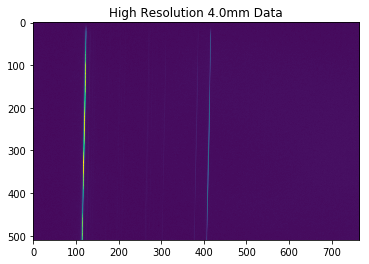

In [24]:
HgHiRes4p0_hdu = pyfits.open(TestSpectrumHiResFiles["Hg"][4.0])
HgHiRes4p0_data = HgHiRes4p0_hdu[0].data

plt.imshow(HgHiRes4p0_data)

plt.title("High Resolution 4.0mm Data")
plt.show()

Two of the strongest lines in these data are the 4358 and the 4047 angstrom line. You may also see the 3650 line in your spectrum. Let's determine exactly which pixel these peaks occur on. The axis is flipped so that red wavelengths (longer) are on the left and blue (shorter) on the right. We have accounted for this in our definition of the `spectrum` function and can now forget about it.

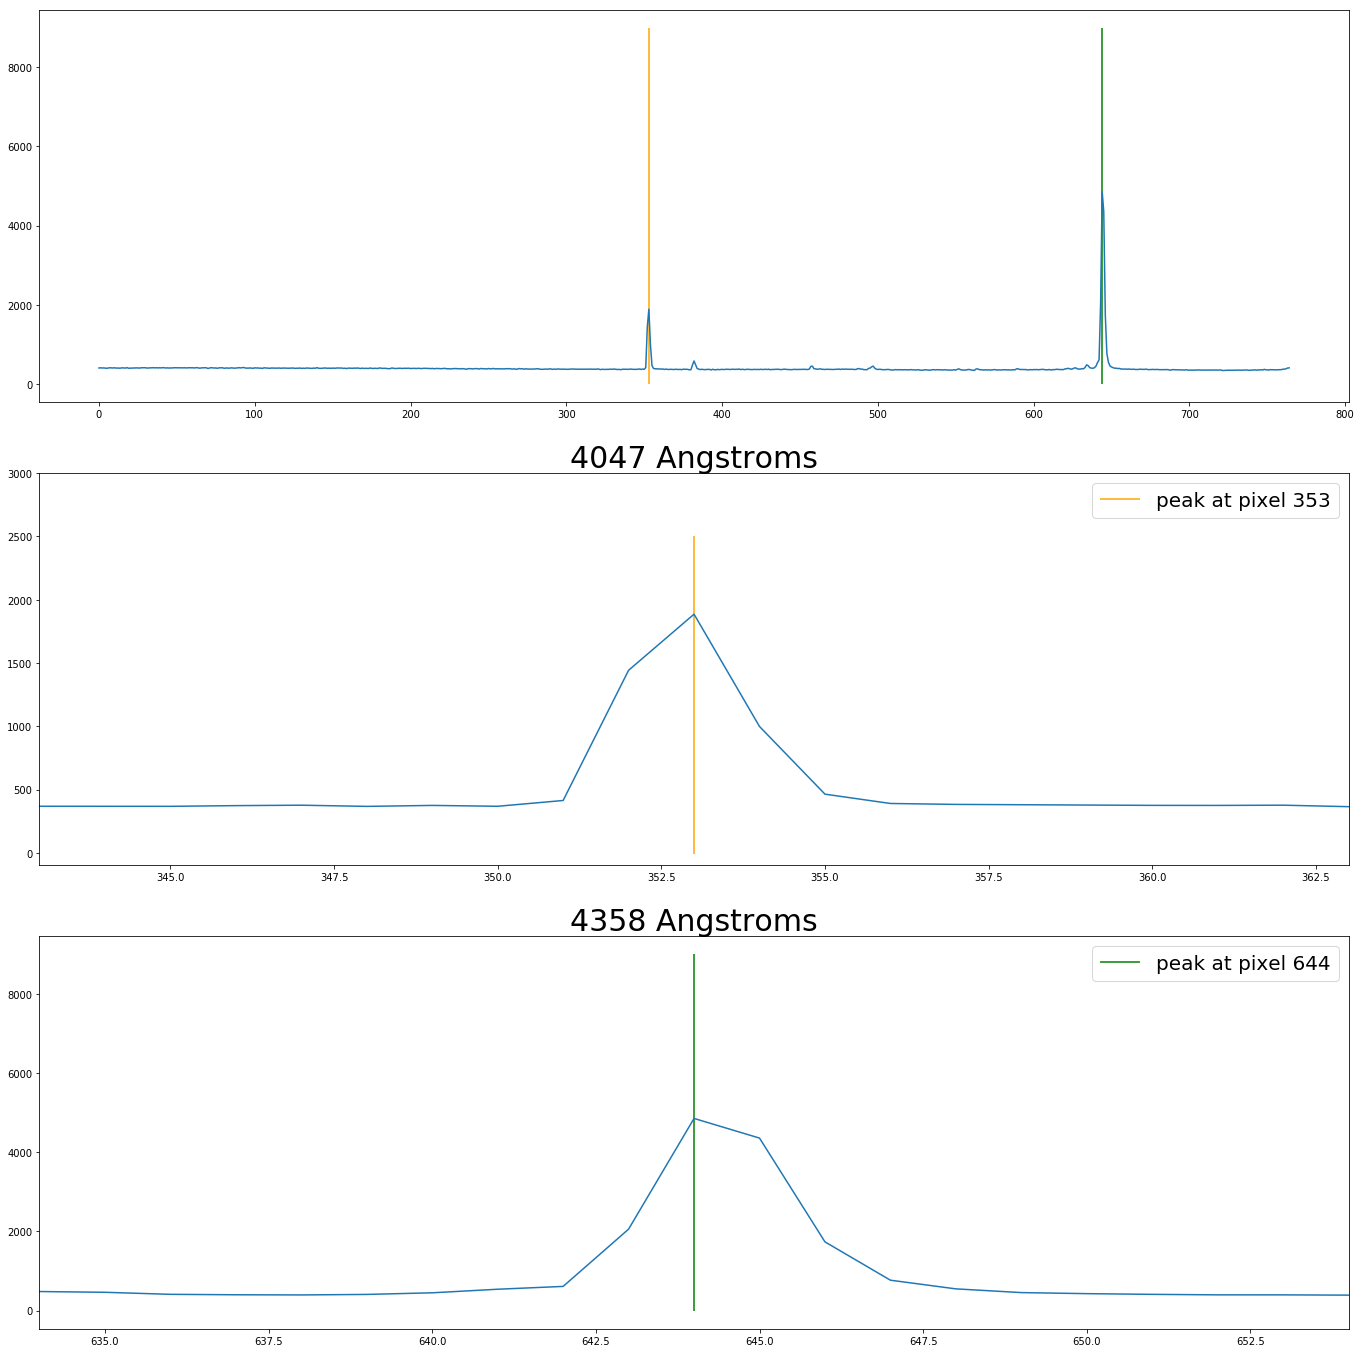

In [27]:
#p1 and p2 are the pixel locations of the lines.  Adjust these as needed.
p1 = 353 ; p2 = 644 ; data = spectrum(HgHiRes4p0_data, 250, 260)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.plot(data)
ax1.plot(data) ; ax1.set_title("4047 Angstroms", fontsize=30)
ax1.vlines(p1, -10, 2500, label="peak at pixel {0}".format(p1), colors='orange')
ax2.plot(data) ; ax2.set_title("4358 Angstroms", fontsize=30)
ax2.vlines(p2, -10, 9000, label="peak at pixel {}".format(p2), colors='g')

ax0.vlines([p1, p2], -10, 9000, colors=['orange', 'g'])

# You may need to adjust the y limits to see the feautes well
ax1.set_xlim(p1-10, p1+10)
ax1.set_ylim(-100,3000)
ax2.set_xlim(p2-10, p2+10)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

plt.show()

Now that we know the corresponding pixels, we can determine the focal length of our instrument's lens. 

In [28]:
# l1 = 3650.153 ; l2 = 4358.328
l1 = 4046.56; l2 = 4358.328
#focal length should be about 138 mm 
focal_len = f(p1, p2, l1, l2)
print("calculated focal length:", focal_len)

calculated focal length: 138.09148428927537 mm


Success! Since we were able to identify two lines, we can proceed with identifying features in the Solar spectrum at the same micrometer setting.

In [13]:
# SunHiRes4p0_hdu = pyfits.open(HighResFiles["Sun"][4.0])
SunHiRes4p0_hdu = pyfits.open(TestSpectrumHiResFiles["Sun"][4.0])
SunHiRes4p0_data = SunHiRes4p0_hdu[0].data
data = spectrum(SunHiRes4p0_data, 250, 260)

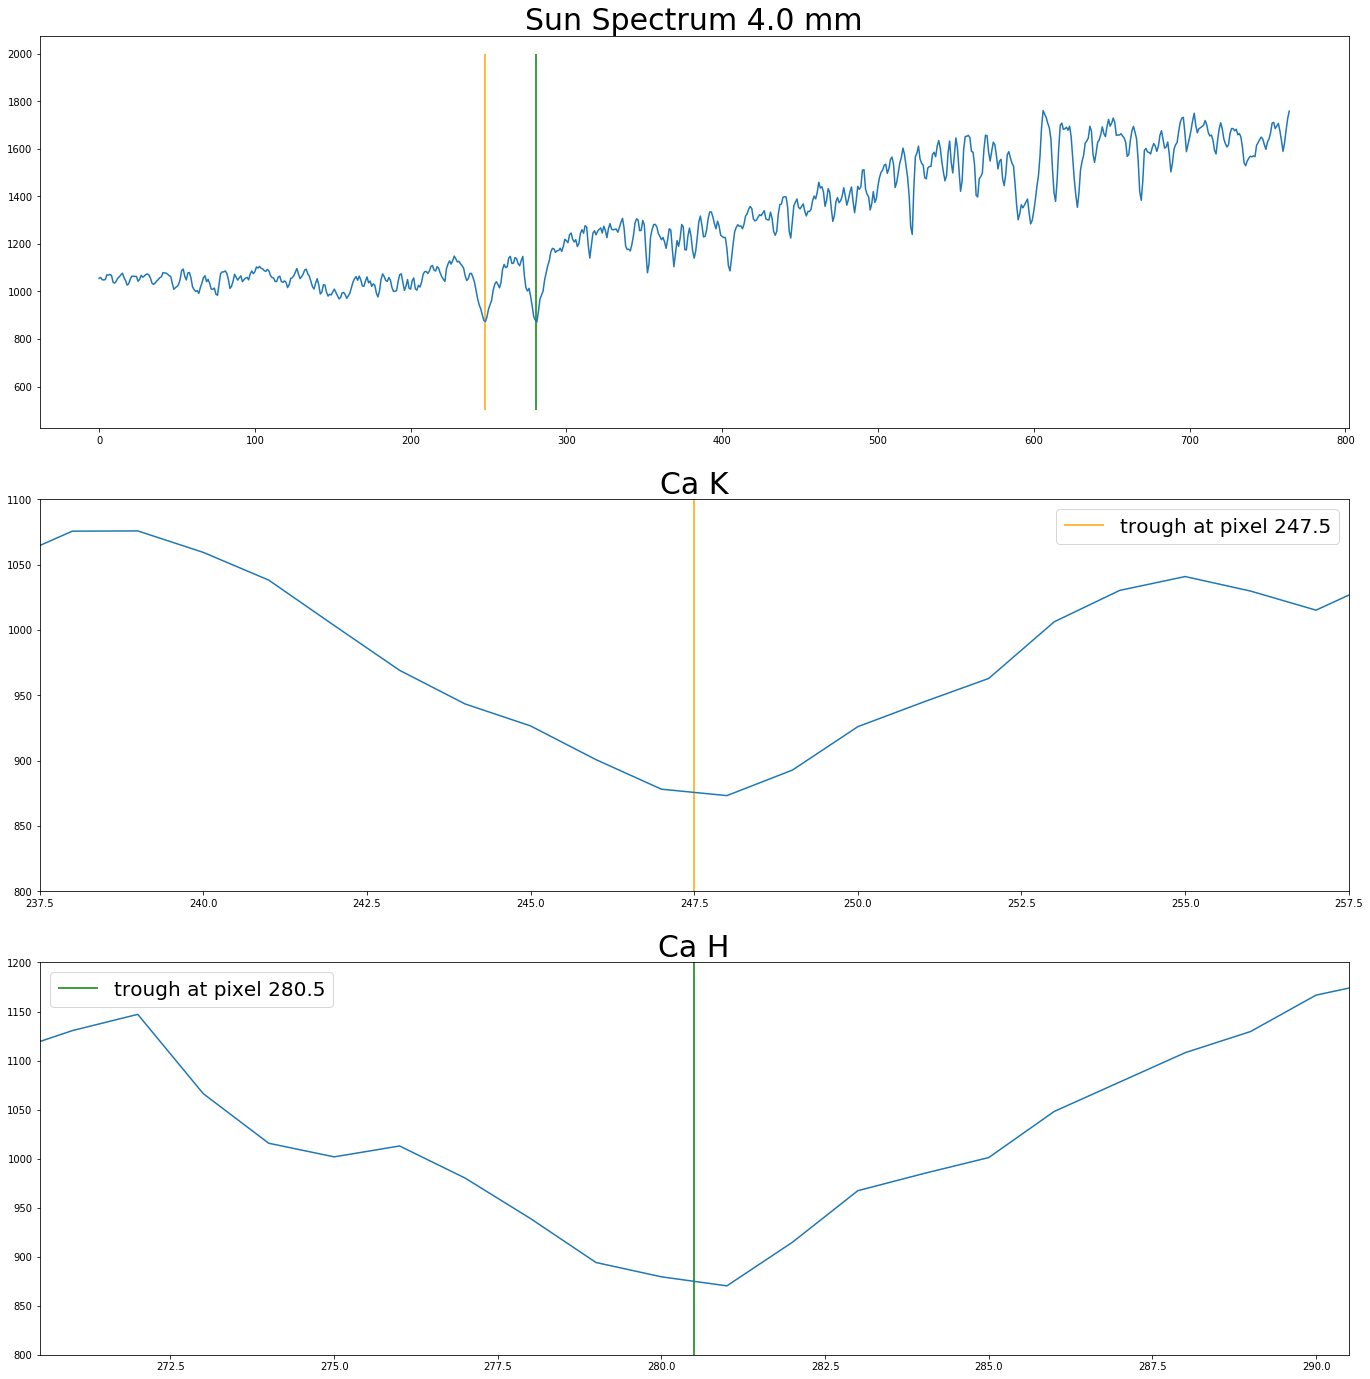

In [14]:
# Here we will identify the Ca H and K lines in the 4.0mm spectrum.
# There are additional lines that you may see at this setting,
# and you should identify other lines for the other micrometer settings.
# Adjust the pixel values below add or subtract lines as needed.
psun1 = 247.5
psun2 = 280.5

lsun1 = wavelength2(psun1, p1, p2, l1, l2)
lsun2 = wavelength2(psun2, p1, p2, l1, l2)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum 4.0 mm", fontsize=30)
ax0.plot(data)
ax1.plot(data);
ax1.set_title("Ca K", fontsize=30)
ax1.vlines(psun1, 500, 2000, label="trough at pixel {0}".format(psun1), colors='orange')
ax2.plot(data);
ax2.set_title("Ca H", fontsize=30)
ax2.vlines(psun2, 500, 2000, label="trough at pixel {}".format(psun2), colors='g')

ax0.vlines([psun1, psun2], 500, 2000, colors=['orange', 'g'])

# You may need to adjust the y limits to see the feautes well
ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(800, 1100)
ax2.set_xlim(psun2-10, psun2+10)
ax2.set_ylim(800, 1200)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

plt.show()

In [15]:
import pandas as pd

#Update these wavelengths to whichever lines you think you see
#in the particular spectrum you are looking at.
lam1 = 3933.66 # Literature value for Ca K
lam2 = 3968.47 # Literature value for Ca H

index = ["K", "H"]
frame = {u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2]}

df = pd.DataFrame(frame, index=index)
display(df)

,Measured Wavelength (Å),Literature Wavelength (Å),Error (Å),Error (%)
K,3933.724583,3933.66,0.064583,0.001642
H,3969.019074,3968.47,0.549074,0.013836


If we had not been able to determine the locations of two calibration lines, we would need to use the now known focal length plus one calbration line. Since the focal length of the lens is constant throughout all readings, all we need to determine for each new micrometer setting is $\theta_i$, which does change whenever the instrument is moved to look at a new part of the spectrum. 

I defined a `thetai` function above, but this is the calculation of $\theta_i$ where we don't know the focal length. Since we now know the focal length, we can use the following function to determine $\theta_i$: 

In [16]:
def theta_i(p1, lambda1, f, d=(1/600)*(u.millimeter), delta=9*u.micrometer, psi=6.35*u.degree):
    lambda1 = lambda1*u.angstrom ; lambda1 = lambda1.to(u.micrometer)
    f = f.to(u.micrometer)
    p1prime = ((delta / f) * (p1 - 381)).to(u.rad, equivalencies=u.dimensionless_angles())
    return np.arcsin(lambda1/(2*d*np.cos(psi)*np.cos(p1prime))) - (p1prime / 2.)

Using this function, all we need is one calibration line per data frame. Let's double check a few things to make sure the calibration is working properly. Be careful in the code below which prints the approximate wavelength of pixel 381 (the central pixel); the micrometer setting of 4 is hard coded.  You will need the change this to get the central wavelength for the other spectra.

In [17]:
theta_4 = theta_i(p2, l2, focal_len) # Get calibration constant for this micrometer setting
print(theta_4)

0.1233869701493574 rad


In addition to giving a sanity check, the central wavelength and wavelength range below can help you to know which solar features to look for in a given spectrum.

In [18]:
print(wavelength(0, theta_4, focal_len).to(u.angstrom)) # Wavelength of left side of image
print(wavelength(764, theta_4, focal_len).to(u.angstrom)) # Wavelength of right side of image
print(wavelength(381, theta_4, focal_len).to(u.angstrom)) # Wavelength of pixel 381
# Change 4. below to the appropriate micrometer setting
print((40. + 987.5 * 4.) * u.angstrom) # Approximate wavelength of pixel 381

3669.227189490386 Angstrom
4486.254957713912 Angstrom
4077.301499396131 Angstrom
3990.0 Angstrom


This seems to work out (the image should be about 40 nm to either side of the central wavelength determined by the micrometer setting). Let's take a look at the Sun spectrum again with this calibration.

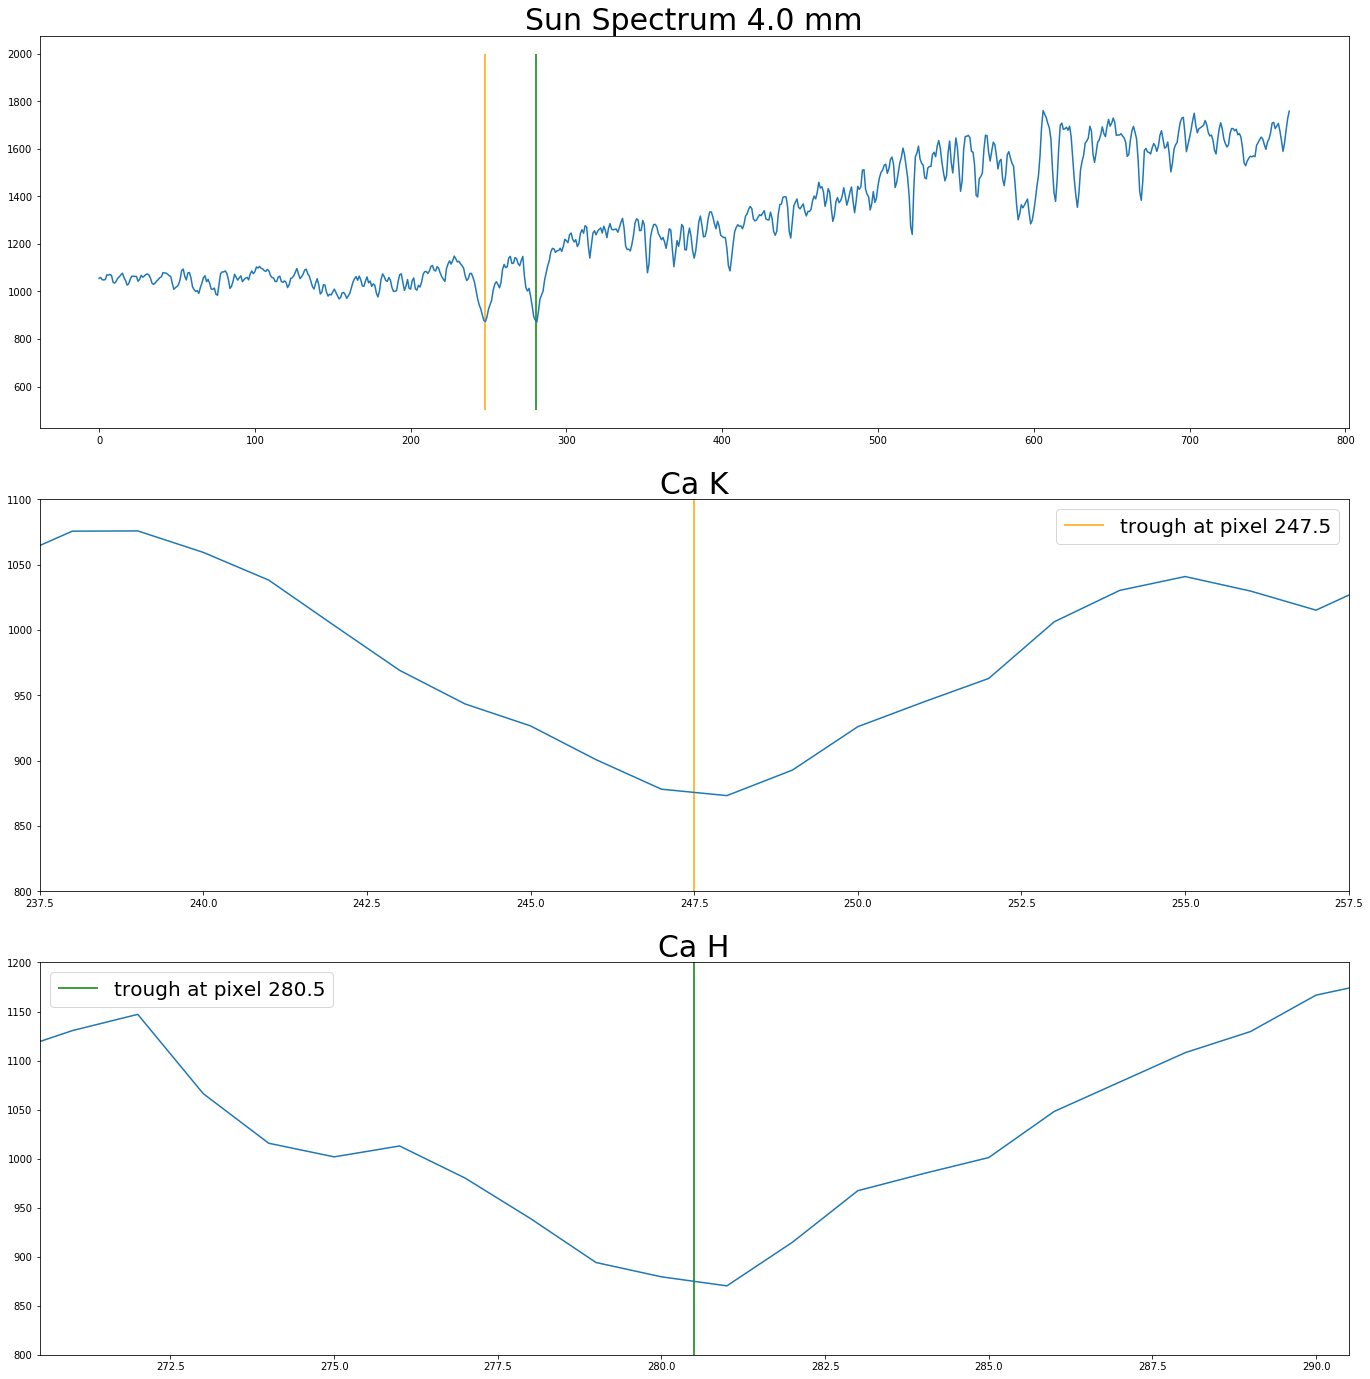

In [19]:
# Here we will identify the Ca H and K lines in the 4.0mm spectrum.
# There are additional lines that you may see at this setting,
# and you should identify other lines for the other micrometer settings.
# Adjust the pixel values below add or subtract lines as needed.
psun1 = 247.5
psun2 = 280.5

lsun1 = wavelength(psun1, theta_4, focal_len)
lsun2 = wavelength(psun2, theta_4, focal_len)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20))
fig.tight_layout(pad=5)
ax0.set_title("Sun Spectrum 4.0 mm", fontsize=30)
ax0.plot(data)
ax1.plot(data);
ax1.set_title("Ca K", fontsize=30)
ax1.vlines(psun1, 500, 2000, label="trough at pixel {0}".format(psun1), colors='orange')
ax2.plot(data);
ax2.set_title("Ca H", fontsize=30)
ax2.vlines(psun2, 500, 2000, label="trough at pixel {}".format(psun2), colors='g')

ax0.vlines([psun1, psun2], 500, 2000, colors=['orange', 'g'])

# You may need to adjust the y limits to see the feautes well
ax1.set_xlim(psun1-10, psun1+10)
ax1.set_ylim(800, 1100)
ax2.set_xlim(psun2-10, psun2+10)
ax2.set_ylim(800, 1200)

ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

plt.show()

In [20]:
import pandas as pd

lsun1 = wavelength(psun1, theta_4, focal_len).to(u.angstrom).value # Measured wavelength of absorption line 1
lsun2 = wavelength(psun2, theta_4, focal_len).to(u.angstrom).value # Measured wavelength of absorption line 2

#Update these wavelengths to whichever lines you think you see
#in the particular spectrum you are looking at.
lam1 = 3933.66 # Literature value for Fraunhofer K
lam2 = 3968.47 # Literature value for Fraunhofer H

index = ["K", "H"]
frame = {u"Measured Wavelength (\u212b)" : [lsun1, lsun2],
         u"Literature Wavelength (\u212b)" : [lam1, lam2],
         u"Error (\u212b)" : [lsun1 - lam1, lsun2 - lam2],
         u"Error (%)" : [100. * (lsun1 - lam1) / lam1, 100. * (lsun2 - lam2) / lam2]}

df = pd.DataFrame(frame, index=index)
display(df)

,Measured Wavelength (Å),Literature Wavelength (Å),Error (Å),Error (%)
K,3934.444564,3933.66,0.784564,0.019945
H,3969.771239,3968.47,1.301239,0.032789


This worked, but you can see the calibration is not as good as the previous one in this case.  For the other micrometer settings, if you can identify more than one mercury-argon line, you can use the additional lines as a measure of the systematic uncertainties, and/or you can use the two line wavelength calibration and compare the focal lengths you get.

## Comparison to stellar spectra

Also provided in test_spectra/ are spectral templates for G2, K2, F2, and M2 type stars composed of the summed real data of stars of these types from the Sloan Digital Sky Survey (Kesseli et al. 2017).  The code below shows how to displat thse on top of your data.  Note that to actually get a good comparison, you would need to include at least a linear component to account for atmospheric scattering.  Often determination of spectral type and redshift would be done by fitting to templates of this kind.  What you can do easily is to look for the absorption features you found in the Sun's spectrum in each of the templates.  Which features distinguish the Sun as being a G2 type star?

In [21]:
#Define the model for importing the spectral templates
def get_model(model_filename):
    model_obj = pyfits.open(model_filename)
    model=model_obj[1].data
    model_lambda = 10**(model.field(0))#    datafilename = 'G2_+0.0_Dwarf.fits'
    model_flux = model.field(1)
    return(model_lambda,model_flux)

In [22]:
#Transform the x-axis from pixel to wavelength
pixelvalues = np.arange(len(data))
wavelengthvalues = wavelength2(pixelvalues, p1, p2, l1, l2)
print("The spectrum runs from ",np.amin(wavelengthvalues)," to ",np.amax(wavelengthvalues))

The spectrum runs from  3669.0159039451105  to  4486.136837049744


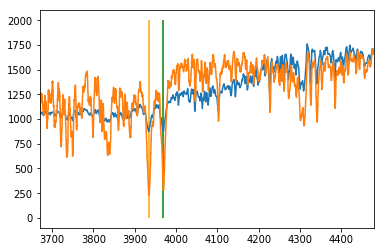

In [23]:
#Load model and plot along with your data
lambda_0 , flux_0 = get_model('test_spectra/G2_+0.0_Dwarf.fits')

interpdat = np.interp(lambda_0,wavelengthvalues,data)
plt.xlim(3670,4480)
#plt.ylim(0,3700)
#plt.rcParams["figure.figsize"] = (15,3)
plt.vlines([lsun1, lsun2], 0, 2000, colors=['orange', 'g'])
plt.plot(lambda_0,interpdat)
# You will likely need to play with the sclaing below for different spectra
scale_model0 = flux_0*max(interpdat)/max(flux_0)
plt.plot(lambda_0,scale_model0)